# Calculating monthly averages and other summaries from daily projections from Cal-Adapt API

Begin by importing all python modules we will need.

In [1]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

import requests 
import numpy as np
import pandas as pd
from datetime import datetime

### You can get data for a point or an area of your interest

If you are requesting data for a point or polygon use the `g` parameter to specify geometry. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

In [3]:
# Uncomment the following lines to get data for a point location
#point = 'POINT(-121.4687 38.5938)'
#params = {'g': point}

# Uncomment the following lines to get data for a polygon
#polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
#params = {'g': polygon, 'stat': 'mean'}

### If you want to use polygon geometry from Cal-Adapt API, it's a 2-step process

- First get a polygon from a boundary layer in the API (e.g. counties, census tracts, place, etc.) that intersects your point of interest. Build a string that references the id of the polygon.
- Then use the `ref` param instead of the `g` param to request data

[Complete list of boundaries in Cal-Adapt API](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data). **Note: Requests might time out if the polygon is too large**. Subsetting the daily data has been tested with counties, census tracts, places and hydrounits. If you need data for a large boundary we reccomend downloading the daily rasters and processing the data locally. 

In [5]:
# Your point of interest
point = 'POINT(-121.4687 38.5938)'
# Name of boundary layer in API
resource = 'counties'
# Request url
url = 'https://api.cal-adapt.org/api/%s/' % resource
# Request params to find intersecting boundaries
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}

# Get geometry
response = requests.get(url, params=params)
if response.ok:
    data = response.json()
    feature = data['features'][0]
    if feature:
        ref = '/api/%s/%s/' % (resource, feature['id'])
        print(ref)
    else:
        print('Did not find any polygons that intersect your point')

params = {'ref': ref, 'stat': 'mean', 'imperial': True}

/api/counties/34/


## 1. Get daily data

For this example we will get modeled projections for one scenario (RCP 8.5) and one model (HadGEM2-ES) for a county boundary in the Cal-Adapt API (see `params` in the previous code block).

In [6]:
# Request url
url = 'https://api.cal-adapt.org/api/series/tasmax_day_HadGEM2-ES_rcp85/events/'

# Make request
response = requests.get(url, params=params)

df = pd.read_json(response.text, typ='series', orient='split')

Print the first and last 5 values of the daily timeseries

In [7]:
print(df.head())
print()
print(df.tail())

2006-01-01 00:00:00+00:00    54.150963
2006-01-02 00:00:00+00:00    51.575603
2006-01-03 00:00:00+00:00    51.505348
2006-01-04 00:00:00+00:00    52.059608
2006-01-05 00:00:00+00:00    45.560204
Name: tasmax_day_HadGEM2-ES_rcp85, dtype: float64

2099-12-27 00:00:00+00:00    56.941383
2099-12-28 00:00:00+00:00    61.712799
2099-12-29 00:00:00+00:00    61.135357
2099-12-30 00:00:00+00:00    62.893883
2099-12-31 00:00:00+00:00    64.650047
Name: tasmax_day_HadGEM2-ES_rcp85, dtype: float64


### 2. Calculate annual averages from daily timeseries

In [8]:
df.resample('A').mean()

2006-12-31 00:00:00+00:00    74.931119
2007-12-31 00:00:00+00:00    78.054164
2008-12-31 00:00:00+00:00    75.509373
2009-12-31 00:00:00+00:00    75.518152
2010-12-31 00:00:00+00:00    74.212553
                               ...    
2095-12-31 00:00:00+00:00    85.572199
2096-12-31 00:00:00+00:00    84.141894
2097-12-31 00:00:00+00:00    83.155016
2098-12-31 00:00:00+00:00    85.416611
2099-12-31 00:00:00+00:00    83.789740
Freq: A-DEC, Name: tasmax_day_HadGEM2-ES_rcp85, Length: 94, dtype: float64

/home/brian/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


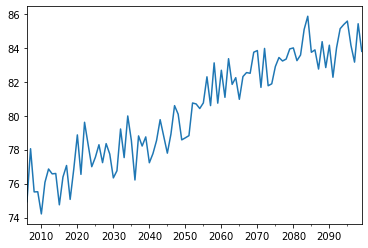

In [9]:
df.resample('A').mean().plot()

### 3. Calculate monthly averages from daily timeseries

In [10]:
monthly_avg = df.resample('M').mean()
monthly_avg

2006-01-31 00:00:00+00:00     55.927527
2006-02-28 00:00:00+00:00     64.960370
2006-03-31 00:00:00+00:00     67.032392
2006-04-30 00:00:00+00:00     77.658930
2006-05-31 00:00:00+00:00     79.353064
                                ...    
2099-08-31 00:00:00+00:00     97.044839
2099-09-30 00:00:00+00:00    100.247714
2099-10-31 00:00:00+00:00     86.373061
2099-11-30 00:00:00+00:00     72.872433
2099-12-31 00:00:00+00:00     64.830973
Freq: M, Name: tasmax_day_HadGEM2-ES_rcp85, Length: 1128, dtype: float64

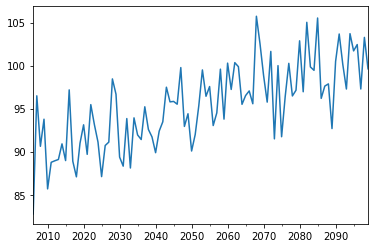

In [11]:
jun_avg = monthly_avg[monthly_avg.index.month == 6]
jun_avg.plot()

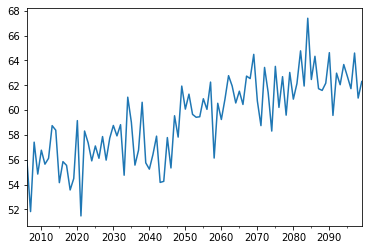

In [12]:
jan_avg = monthly_avg[monthly_avg.index.month == 1]
jan_avg.plot()

### 4. Export dataframe to csv file

In [12]:
monthly_avg.to_csv('monthly_avg.csv')